In [55]:
# Starter cell: load POWER logs (clean + spans) and FREEZER temp logs
# Produces:
#   - df              (cleaned power rows)
#   - log_spans_cut   (CSV file spans, clipped to cutoff)
#   - temp_df         (freezer temperatures, wide format with ch1..ch4)
#   - TEMP_COLS       (list[str] channels inside temp_df)

from pathlib import Path
from typing import Optional
import pandas as pd
import numpy as np
import re

# ──────────────────────────────────────────────────────────────────────────────
# Paths
# ──────────────────────────────────────────────────────────────────────────────
DATA_DIR = Path("../data-2025")
FREEZER_DIR = DATA_DIR / "freezer-temp"

if not DATA_DIR.exists():
    raise FileNotFoundError(f"Data directory not found: {DATA_DIR.resolve()}")

# ──────────────────────────────────────────────────────────────────────────────
# Load POWER logs + spans
# ──────────────────────────────────────────────────────────────────────────────
power_paths = sorted(
    p for p in DATA_DIR.rglob("*.csv")
    if FREEZER_DIR not in p.parents    # skip freezer here (we'll load separately)
)

frames, spans = [], []
expected_cols = ["timestamp","mode","value","vbat_mV","vin_mV","iout_mA","soc_C","rp1_C","pmic_C","error"]

for p in power_paths:
    try:
        tmp = pd.read_csv(p, dtype=str)
    except Exception as e:
        print(f"Warning: failed to read {p}: {e}")
        continue

    for col in expected_cols:
        if col not in tmp.columns:
            tmp[col] = np.nan

    tmp["value_str"] = tmp["value"].astype(str)
    tmp["mode"]  = tmp["mode"].astype(str).str.strip().str.lower()
    tmp["error"] = tmp["error"].astype(str).fillna("").str.strip()
    tmp["timestamp"] = pd.to_datetime(tmp["timestamp"], errors="coerce")

    valid_ts = tmp["timestamp"].dropna()
    if not valid_ts.empty:
        spans.append({"source_file": str(p), "start": valid_ts.min(), "end": valid_ts.max()})

    tmp["source_file"] = str(p)
    frames.append(tmp)

if frames:
    df = pd.concat(frames, ignore_index=True)
    df = df.dropna(subset=["timestamp"]).sort_values("timestamp")
else:
    df = pd.DataFrame(columns=expected_cols + ["value_str","source_file"])

log_spans = pd.DataFrame(spans) if spans else pd.DataFrame(columns=["source_file","start","end"])
log_spans = log_spans.sort_values(["start","end"]).reset_index(drop=True)

print(f"Loaded POWER CSVs: {len(frames)} files; power rows: {len(df)}")
if not log_spans.empty:
    print(f"Power file spans: {len(log_spans)}  ({log_spans['start'].min()} → {log_spans['end'].max()})")

# ──────────────────────────────────────────────────────────────────────────────
# POWER cleaning
# ──────────────────────────────────────────────────────────────────────────────
CUTOFF_DATE = pd.Timestamp("2025-08-21")
before_rows = len(df)
df = df[df["timestamp"] >= CUTOFF_DATE].copy()
print(f"[Power Step 1] Cutoff @ {CUTOFF_DATE.date()}: kept {len(df)} / {before_rows}")

if not log_spans.empty:
    log_spans_cut = log_spans.copy()
    log_spans_cut = log_spans_cut[log_spans_cut["end"] >= CUTOFF_DATE].copy()
    log_spans_cut["start"] = log_spans_cut["start"].where(log_spans_cut["start"] >= CUTOFF_DATE, CUTOFF_DATE)
    log_spans_cut = log_spans_cut[log_spans_cut["start"] < log_spans_cut["end"]].reset_index(drop=True)
else:
    log_spans_cut = log_spans.copy()

pre_rows = len(df)
df = df[df["mode"].eq("watt")].copy()
print(f"[Power Step 2] Discarded non-'watt': {pre_rows - len(df)}; remaining: {len(df)}")

pre_rows = len(df)
sentinel_mask = df["value_str"].astype(str).str.contains("8888.8000", regex=False, na=False)
df = df[~sentinel_mask].copy()
print(f"[Power Step 3] Discarded value contains '8888.8000': {pre_rows - len(df)}; remaining: {len(df)}")

pre_rows = len(df)
val_num_tmp = pd.to_numeric(df["value_str"].str.replace(r"[^\d.\-]", "", regex=True), errors="coerce")
zero_or_nan = val_num_tmp.isna() | val_num_tmp.eq(0)
# non-capturing groups to avoid the warning
err_decode = df["error"].str.contains(r"(?:decode|segment|unrecognized|fail|parse)", case=False, na=False)
drop_mask = err_decode & zero_or_nan
df = df[~drop_mask].copy()
print(f"[Power Step 4] Discarded decode/segment AND 0/NaN: {pre_rows - len(df)}; remaining: {len(df)}")

for num_col in ["value","vbat_mV","vin_mV","iout_mA","soc_C","rp1_C","pmic_C"]:
    df[num_col] = pd.to_numeric(df[num_col], errors="coerce")

# ──────────────────────────────────────────────────────────────────────────────
# Load FREEZER temperature logs (TXT or CSV), whitespace- or comma-delimited
# Expected headers (case-insensitive): MN/AT, date, time, int, 1ch, 2ch, 3ch, 4ch, unit
# ──────────────────────────────────────────────────────────────────────────────
def read_freezer_file(p: Path) -> Optional[pd.DataFrame]:
    """Return a DataFrame with columns: timestamp, ch1..ch4, source_file. None if un-parseable."""
    try:
        with open(p, "r", errors="ignore") as fh:
            first = fh.readline()
    except Exception as e:
        print(f"Warning: cannot open {p}: {e}")
        return None

    try:
        if "," in first:
            t = pd.read_csv(p, dtype=str)
        else:
            t = pd.read_csv(p, dtype=str, sep=r"\s+", engine="python")
    except Exception as e:
        print(f"Warning: failed to read freezer file {p}: {e}")
        return None

    # normalize headers
    t.columns = [str(c).strip().lower() for c in t.columns]

    # combine date + time → timestamp
    if "timestamp" in t.columns:
        t["timestamp"] = pd.to_datetime(t["timestamp"], errors="coerce")
    elif "date" in t.columns and "time" in t.columns:
        t["timestamp"] = pd.to_datetime(t["date"].astype(str) + " " + t["time"].astype(str), errors="coerce")
    elif "datetime" in t.columns:
        t["timestamp"] = pd.to_datetime(t["datetime"], errors="coerce")
    else:
        print(f"Warning: {p.name}: no timestamp/date+time column(s); skipping.")
        return None

    t = t.dropna(subset=["timestamp"])

    # map channel columns to ch1..ch4
    ch_candidates = []
    for name in t.columns:
        m = re.match(r"^(?:([1-4])ch|ch([1-4])|temp([1-4])|t([1-4]))$", name.strip())
        if m:
            idx = next(int(g) for g in m.groups() if g)
            ch_candidates.append((idx, name))
    if not ch_candidates:
        for k in ["1ch","2ch","3ch","4ch"]:
            if k in t.columns:
                ch_candidates.append((int(k[0]), k))

    if not ch_candidates:
        print(f"Warning: {p.name}: no temperature channel columns; skipping.")
        return None

    ch_candidates.sort(key=lambda x: x[0])
    rename_map = {orig: f"ch{idx}" for idx, orig in ch_candidates[:4]}
    t = t.rename(columns=rename_map)

    keep_cols = ["timestamp"] + list(rename_map.values())
    t = t[[c for c in keep_cols if c in t.columns]].copy()

    # numeric temps
    for c in [col for col in t.columns if col.startswith("ch")]:
        t[c] = pd.to_numeric(t[c], errors="coerce")

    t["source_file"] = str(p)
    return t

temp_frames = []
if FREEZER_DIR.exists():
    freezer_paths = []
    for pat in ("*.txt","*.TXT","*.csv","*.CSV","*.log","*.LOG"):
        freezer_paths += list(FREEZER_DIR.rglob(pat))
    freezer_paths = sorted(set(freezer_paths))

    for p in freezer_paths:
        d = read_freezer_file(p)
        if d is not None and not d.empty:
            temp_frames.append(d)

    if temp_frames:
        temp_df = pd.concat(temp_frames, ignore_index=True)
        temp_df = temp_df.dropna(subset=["timestamp"]).sort_values("timestamp")
        # apply same cutoff
        temp_df = temp_df[temp_df["timestamp"] >= CUTOFF_DATE].copy()
        TEMP_COLS = [c for c in ["ch1","ch2","ch3","ch4"] if c in temp_df.columns]
        print(f"Loaded FREEZER files: {len(temp_frames)}; temp rows: {len(temp_df)}; channels: {TEMP_COLS}")
    else:
        temp_df = pd.DataFrame(columns=["timestamp","ch1","ch2","ch3","ch4","source_file"])
        TEMP_COLS = []
        print("No freezer temp rows loaded (no parsable TXT/CSV).")
else:
    temp_df = pd.DataFrame(columns=["timestamp","ch1","ch2","ch3","ch4","source_file"])
    TEMP_COLS = []
    print(f"Freezer folder not found: {FREEZER_DIR}")

# ──────────────────────────────────────────────────────────────────────────────
# Quick summaries
# ──────────────────────────────────────────────────────────────────────────────
if not df.empty:
    tmin = df["timestamp"].min(); tmax = df["timestamp"].max()
    span = tmax - tmin; total_seconds = int(span.total_seconds())
    days = total_seconds // 86400; rem = total_seconds % 86400
    hours = rem // 3600; rem %= 3600; minutes = rem // 60
    print(f"POWER time span: {tmin} → {tmax}  (Total: {days}d {hours}h {minutes}m)  Files:{df['source_file'].nunique()}")
else:
    print("POWER df is empty after cleaning.")

if not temp_df.empty:
    tmin2 = temp_df["timestamp"].min(); tmax2 = temp_df["timestamp"].max()
    print(f"TEMP  time span: {tmin2} → {tmax2}  Files:{temp_df['source_file'].nunique()}")
else:
    print("TEMP df is empty (check freezer-temp TXT/CSV formatting).")

# Globals for plotting:
#   df, log_spans_cut, temp_df, TEMP_COLS


Loaded POWER CSVs: 32 files; power rows: 234375
Power file spans: 32  (2025-08-18 12:41:45.321000 → 2025-08-29 15:41:16.761000)
[Power Step 1] Cutoff @ 2025-08-21: kept 230935 / 234375
[Power Step 2] Discarded non-'watt': 3869; remaining: 227066
[Power Step 3] Discarded value contains '8888.8000': 0; remaining: 227066
[Power Step 4] Discarded decode/segment AND 0/NaN: 11760; remaining: 215306
Loaded FREEZER files: 12; temp rows: 136607; channels: ['ch1', 'ch2', 'ch3', 'ch4']
POWER time span: 2025-08-22 16:37:50.372000 → 2025-08-29 15:37:08.748000  (Total: 6d 22h 59m)  Files:23
TEMP  time span: 2025-08-22 17:27:04 → 2025-08-30 15:15:47  Files:12


In [103]:
# Despike single-point OCR spikes in power data using a Hampel-style detector
# Adds to df:
#   - df["is_spike"]        (bool): True where a single-sample spike is flagged
#   - df["value_despiked"]  (float): power with spikes replaced by neighbor mean
#
# Tunables:
WINDOW_SEC            = 30      # time window for local median/MAD (around each point)
MAD_K                 = 4.0     # how many MADs away from local median to flag
NEIGHBOR_TOL_W        = 60.0    # neighbors must be within this many watts of each other
MAX_NEIGHBOR_GAP_SEC  = 60.0    # neighbors must be close in time (avoid crossing gaps)
MIN_JUMP_W            = 120.0   # minimum absolute deviation from local median to consider

import numpy as np
import pandas as pd

if df.empty:
    print("df is empty — skipping despike.")
else:
    # Ensure sorted and numeric
    df = df.sort_values("timestamp").copy()
    s = df["value"].astype(float)
    ts = df["timestamp"]

    # Estimate sampling interval to convert WINDOW_SEC → samples (odd window, >=3)
    dt = ts.diff().dt.total_seconds()
    med_dt = float(dt.median()) if dt.notna().any() else 5.0
    win = max(3, int(round(WINDOW_SEC / max(med_dt, 1e-9))))
    if win % 2 == 0:
        win += 1

    # Rolling median and MAD (median absolute deviation)
    med = s.rolling(win, center=True, min_periods=3).median()
    mad = (s - med).abs().rolling(win, center=True, min_periods=3).median()
    sigma = 1.4826 * mad  # robust σ

    # Candidate outliers: large deviation from local median
    diff = (s - med).abs()
    # Guard against zero sigma by adding a tiny floor
    thresh = MAD_K * sigma.clip(lower=1e-9)
    cand = (diff > thresh) & (diff > MIN_JUMP_W)

    # Isolation: neighbors not outliers
    iso = cand & ~cand.shift(1).fillna(False) & ~cand.shift(-1).fillna(False)

    # Neighbor agreement: two neighbors exist, close in value and in time
    prev_v, next_v = s.shift(1), s.shift(-1)
    prev_t, next_t = ts.shift(1), ts.shift(-1)
    neigh_close_val = prev_v.notna() & next_v.notna() & ((prev_v - next_v).abs() <= NEIGHBOR_TOL_W)
    neigh_close_time = (
        prev_t.notna() & next_t.notna() &
        (ts - prev_t).dt.total_seconds().abs().le(MAX_NEIGHBOR_GAP_SEC) &
        (next_t - ts).dt.total_seconds().abs().le(MAX_NEIGHBOR_GAP_SEC)
    )

    spike_mask = iso & neigh_close_val & neigh_close_time

    df["is_spike"] = spike_mask.fillna(False)

    # Build filtered series: replace spikes with neighbor mean (no gap-bridging)
    filt = s.copy()
    repl = (prev_v + next_v) / 2.0
    filt.loc[spike_mask] = repl.loc[spike_mask]
    df["value_despiked"] = filt

    # Quick summary
    n_spikes = int(df["is_spike"].sum())
    pct = 100.0 * n_spikes / len(df) if len(df) else 0.0
    print(f"Despike window: ~{WINDOW_SEC}s ≈ {win} samples  |  Hampel K={MAD_K}, tol={NEIGHBOR_TOL_W} W")
    print(f"Flagged isolated spikes: {n_spikes} / {len(df)} rows ({pct:.3f}%)")


Despike window: ~30s ≈ 15 samples  |  Hampel K=4.0, tol=60.0 W
Flagged isolated spikes: 130 / 215306 rows (0.060%)


In [51]:
# Chart: Watts vs Time (cleaned df) with generator intervals overlay
# - Power plotted as LINES (no markers), but ONLY within logfile spans (no bridging across gaps)
# - Thick red line at y=0 for each CSV file span (from log_spans_cut)
# - 2000 x 1000 PNG, daily major ticks ("Friday 8/29") LEFT-ALIGNED, faint hourly grid, night shading

import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# ───────────── CONFIG ─────────────
PLOT_SCOPE = "all"      # "all" or "subset"
SUBSET_STYLE = "window"  # "window" or "around"

# (A) Time window:
SUBSET_START = "2025-08-25 18:00:00"
SUBSET_END   = "2025-08-25 21:00:00"

# (B) Time around a center point (± minutes):
CENTER_TIME  = "2025-08-25 19:05:00"
RADIUS_MIN   = 10

OUT_PNG = "power_watts_all_with_spans.png" if PLOT_SCOPE == "all" else "power_watts_subset_with_spans.png"
PRINT_MAX_ROWS = 500
SAVE_SUBSET_CSV = True
SUBSET_CSV_PATH = "subset_rows_for_manual_check.csv"

SUNRISE_STR = "06:22:28"
SUNSET_STR  = "19:31:14"

FIGSIZE_IN = (30, 5)  # 2000x1000 at 200 DPI
DPI = 200

LINE_COLOR = "darkgreen"
LINE_WIDTH = 1.0
# ──────────────────────────────────

def _fmt_day(x, pos):
    d = mdates.num2date(x)
    try:
        return d.strftime("%A %-m/%-d")   # POSIX
    except ValueError:
        return d.strftime("%A %#m/%#d")   # Windows

def _select_subset(df):
    if SUBSET_STYLE == "window":
        lo = pd.Timestamp(SUBSET_START); hi = pd.Timestamp(SUBSET_END)
        m = (df["timestamp"] >= lo) & (df["timestamp"] <= hi)
        return df.loc[m].copy(), f"time window {lo} → {hi}"
    elif SUBSET_STYLE == "around":
        c = pd.Timestamp(CENTER_TIME)
        lo = c - pd.Timedelta(minutes=RADIUS_MIN); hi = c + pd.Timedelta(minutes=RADIUS_MIN)
        m = (df["timestamp"] >= lo) & (df["timestamp"] <= hi)
        return df.loc[m].copy(), f"{RADIUS_MIN} min around {c}  (window {lo} → {hi})"
    else:
        raise ValueError("SUBSET_STYLE must be 'window' or 'around'")

if df.empty:
    print("Cleaned DataFrame `df` is empty — nothing to plot.")
else:
    if PLOT_SCOPE == "all":
        plot_df = df.copy(); scope_desc = "ALL cleaned data"
    else:
        plot_df, scope_desc = _select_subset(df)
        if plot_df.empty:
            print(f"Subset selection produced 0 rows ({scope_desc}). Nothing to plot.")
            print("Data range:", df['timestamp'].min(), "→", df['timestamp'].max(), f"(rows={len(df)})")
        else:
            cols_to_show = [c for c in ["timestamp","value","mode","error","source_file","vbat_mV","vin_mV","iout_mA","soc_C","rp1_C","pmic_C"] if c in plot_df.columns]
            print(f"\nSubset rows selected ({len(plot_df)} rows) — {scope_desc}")
            if len(plot_df) > PRINT_MAX_ROWS:
                print(plot_df[cols_to_show].head(PRINT_MAX_ROWS).to_string(index=False))
                print(f"... ({len(plot_df) - PRINT_MAX_ROWS} more rows not shown)")
            else:
                print(plot_df[cols_to_show].to_string(index=False))
            if SAVE_SUBSET_CSV:
                plot_df.to_csv(SUBSET_CSV_PATH, index=False)
                print(f"Saved subset to CSV: {SUBSET_CSV_PATH}")

    if not plot_df.empty:
        plot_df = plot_df.sort_values("timestamp")
        watts_all = plot_df[["timestamp","value"]].rename(columns={"value":"watts"}).dropna()

        sunrise_t = dt.datetime.strptime(SUNRISE_STR, "%H:%M:%S").time()
        sunset_t  = dt.datetime.strptime(SUNSET_STR,  "%H:%M:%S").time()

        fig = plt.figure(figsize=FIGSIZE_IN, dpi=DPI)
        ax = fig.add_subplot(111)

        left_data, right_data = watts_all["timestamp"].min(), watts_all["timestamp"].max()

        # Major day ticks (LEFT-ALIGNED labels), hourly minor grid
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
        ax.xaxis.set_major_formatter(FuncFormatter(_fmt_day))
        ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
        ax.grid(which="minor", axis="x", linestyle="-", linewidth=0.5, alpha=0.3, color="0.8")

        # LEFT-align the major tick labels
        for lbl in ax.get_xticklabels(which="major"):
            lbl.set_ha("left")
        ax.tick_params(axis="x", which="major", pad=6)
        ax.margins(x=0.01)  # tiny x-padding so the last left-aligned label isn't clipped

        # Night shading
        day_start = left_data.normalize()
        day_end   = (right_data.normalize() + pd.Timedelta(days=1))
        current = day_start
        while current < day_end:
            sr = pd.Timestamp.combine(current, sunrise_t)
            ss = pd.Timestamp.combine(current, sunset_t)
            l1, r1 = max(current, left_data), min(sr, right_data)
            l2, r2 = max(ss, left_data), min(current + pd.Timedelta(days=1), right_data)
            if l1 < r1: ax.axvspan(l1, r1, alpha=0.12, zorder=0)
            if l2 < r2: ax.axvspan(l2, r2, alpha=0.12, zorder=0)
            current += pd.Timedelta(days=1)

        # Generator-on overlay and segmented power lines
        spans_df = None
        try:
            spans_df = log_spans_cut.copy()
        except NameError:
            try:
                spans_df = log_spans.copy()
            except NameError:
                spans_df = None

        if spans_df is not None and not spans_df.empty:
            spans_view = spans_df.copy()
            spans_view["start"] = spans_view["start"].clip(lower=left_data)
            spans_view["end"]   = spans_view["end"].clip(upper=right_data)
            spans_view = spans_view[spans_view["start"] < spans_view["end"]]

            for _, r in spans_view.iterrows():
                m = (watts_all["timestamp"] >= r["start"]) & (watts_all["timestamp"] <= r["end"])
                seg = watts_all.loc[m]
                if len(seg) >= 2:
                    ax.plot(seg["timestamp"], seg["watts"],
                            linestyle="-", marker="o", markersize=0,
                            linewidth=LINE_WIDTH, color=LINE_COLOR, zorder=3)
                ax.hlines(y=0, xmin=r["start"], xmax=r["end"],
                          linewidth=3, color="red", alpha=0.7, zorder=2)
        else:
            ax.plot(watts_all["timestamp"], watts_all["watts"],
                    linestyle="-", marker="o", markersize=0,
                    linewidth=LINE_WIDTH, color=LINE_COLOR, zorder=3)

        ax.set_ylabel("Watts")
        ax.set_xlabel("Time")
        ax.set_title(f"Watts vs Time — {scope_desc}")

        ymin, ymax = ax.get_ylim()
        ax.set_ylim(bottom=min(0, ymin))

        plt.tight_layout()
        plt.savefig(OUT_PNG, dpi=DPI)
        plt.close(fig)
        print(f"\nSaved {OUT_PNG}")



Saved power_watts_all_with_spans.png


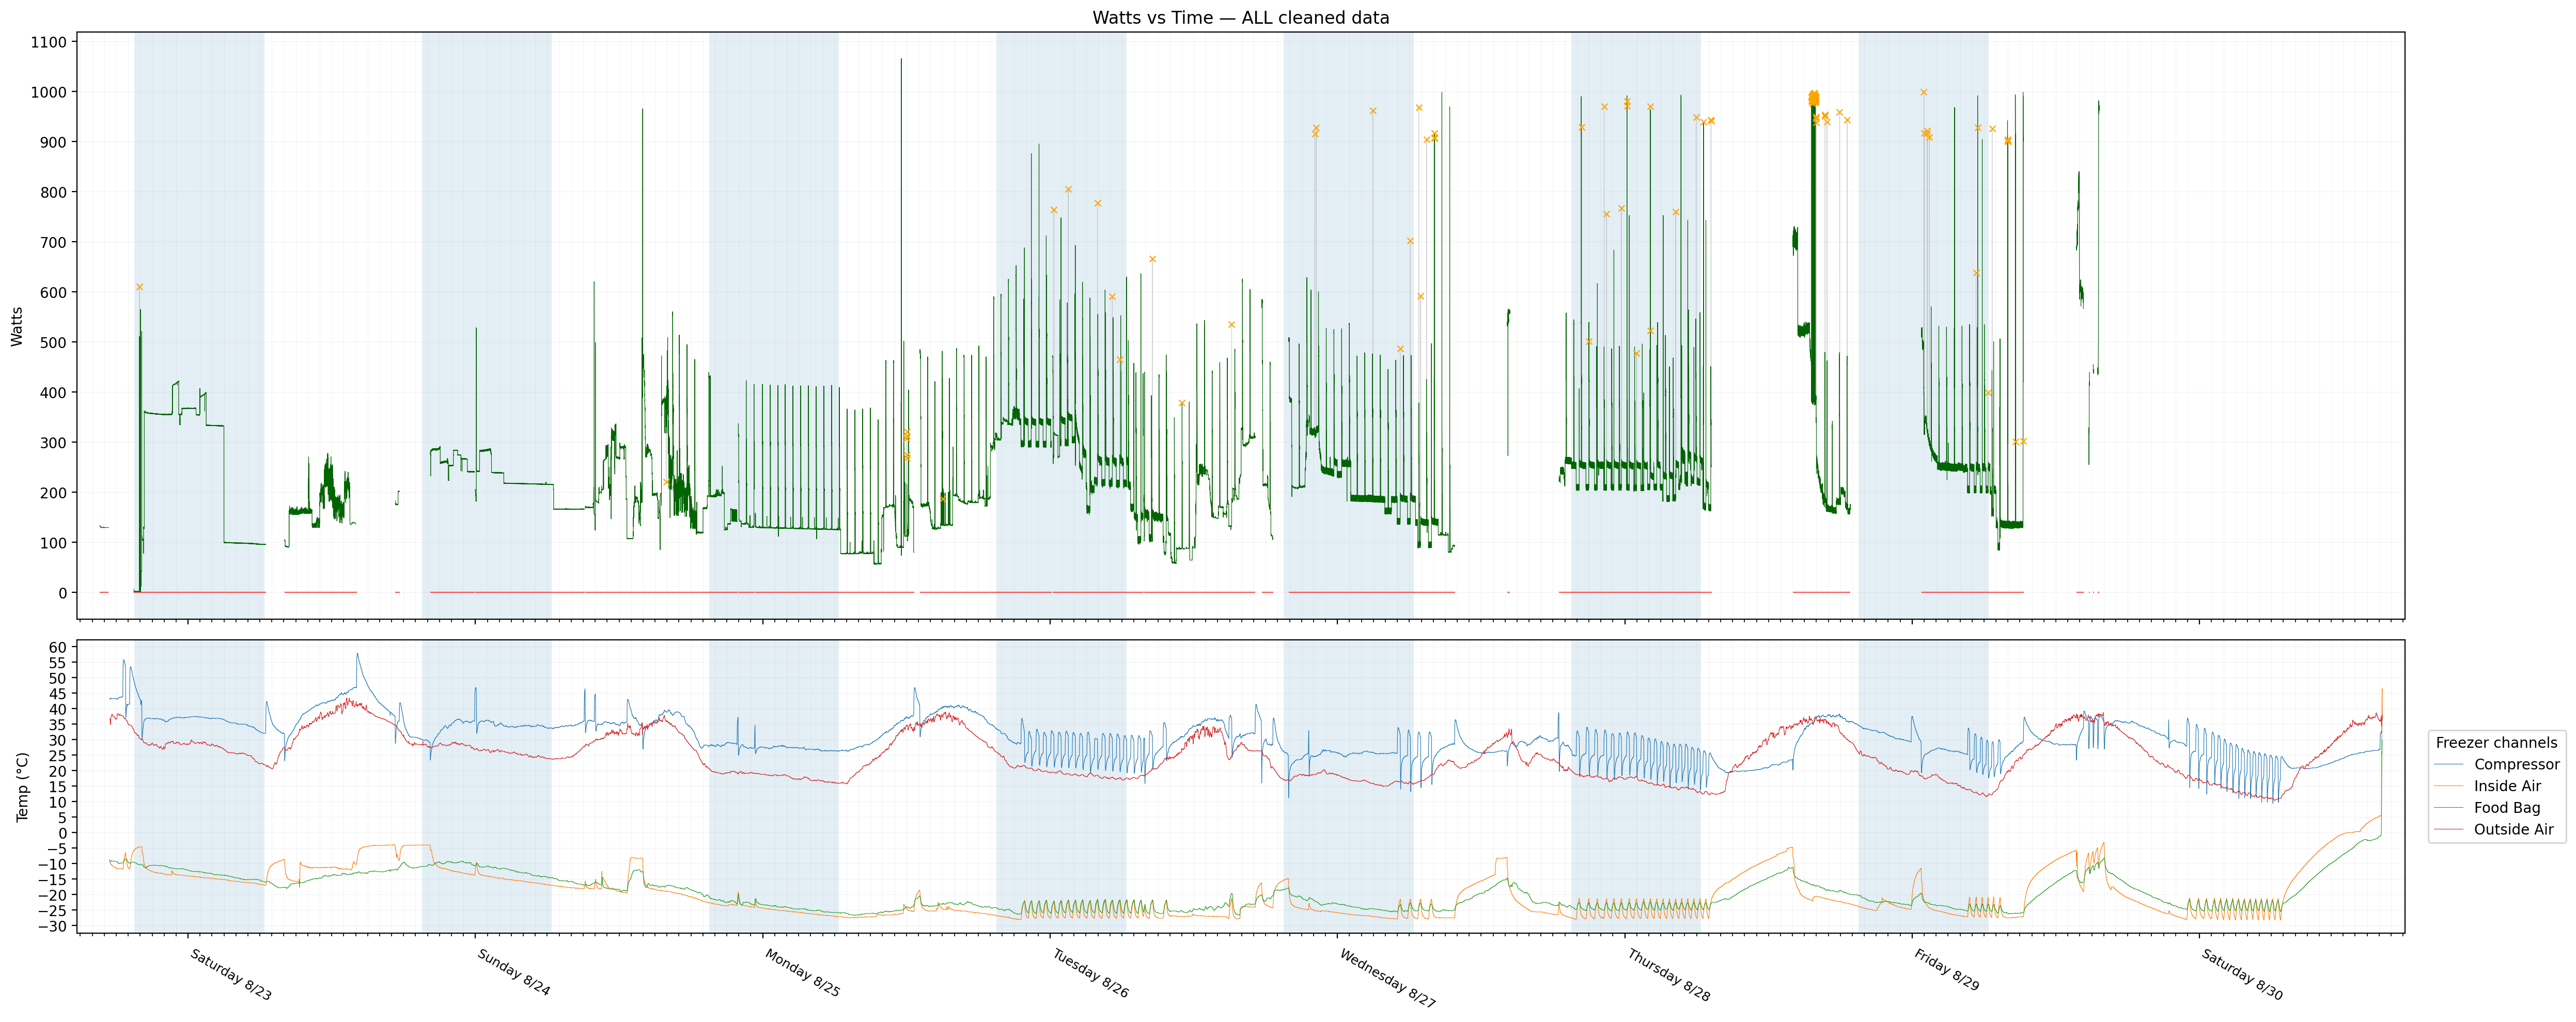


[df] Power subset rows (215306): ALL cleaned data
              timestamp  value  value_despiked  is_spike mode error                      source_file  vbat_mV  vin_mV  iout_mA  soc_C  rp1_C  pmic_C
2025-08-22 16:37:50.372 133.28          133.28     False watt   nan ..\data-2025\20250822_163732.csv     3616    5060      254   53.7    NaN     NaN
2025-08-22 16:38:16.371 133.16          133.16     False watt   nan ..\data-2025\20250822_163732.csv     3616    5060      271   54.8    NaN     NaN
2025-08-22 16:38:34.372 132.25          132.25     False watt   nan ..\data-2025\20250822_163732.csv     3617    5056      269   54.2    NaN     NaN
2025-08-22 16:39:44.377 131.25          131.25     False watt   nan ..\data-2025\20250822_163732.csv     3617    5060      244   54.8    NaN     NaN
2025-08-22 16:40:22.377 131.26          131.26     False watt   nan ..\data-2025\20250822_163732.csv     3617    5053      276   55.8    NaN     NaN
2025-08-22 16:40:28.379 131.00          131.00     Fals

In [104]:
# Two-panel chart with despiked overlay and spike markers
# - Uses df["value_despiked"] when USE_DESPIKED=True (falls back to raw if missing)
# - Overlays the original (raw) series faintly for sanity check
# - Marks flagged spikes (orange "x")
# - Inline PNG display first, then optional prints (subset rows, raw power CSV rows)
# - Vector PDF optional (with optional rasterization)

import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter, MultipleLocator
from pathlib import Path
from IPython.display import display, Image

# ───────────── CONFIG ─────────────
PLOT_SCOPE        = "all"   # "all" or "subset"
SUBSET_STYLE      = "around"   # "window" or "around"
SUBSET_START = "2025-08-25 18:00:00"
SUBSET_END   = "2025-08-25 21:00:00"
CENTER_TIME  = "2025-08-22 19:00:00"
RADIUS_MIN   = 10

USE_DESPIKED          = True   # ← use df["value_despiked"] as primary
OVERLAY_RAW_FAINT     = True   # ← also draw the raw series faintly
SHOW_SPIKE_MARKERS    = True   # ← mark df["is_spike"] points

OUT_PNG = "power_plus_freezer.png" if PLOT_SCOPE == "all" else "power_plus_freezer_subset.png"
DISPLAY_WIDTH_PX = 1600

SUNRISE_STR = "06:22:28"
SUNSET_STR  = "19:31:14"

FIGSIZE_IN = (25, 10)
DPI = 200

# Styles
POWER_COLOR      = "darkgreen"  # filtered (primary)
POWER_LINEW      = 0.4
RAW_COLOR        = "0.6"        # faint gray for raw overlay
RAW_ALPHA        = 0.5
RAW_LINEW        = 0.3
SPIKE_COLOR      = "orange"
SPIKE_MS         = 18           # marker size
SPIKE_MW         = 0.8          # marker edgewidth
BASELINE_COLOR   = "red"
BASELINE_LINEW   = 0.8
TEMP_LINEW       = 0.4

GRID_X_LW_MINOR  = 0.3
GRID_Y_LW_MAJOR  = 0.25

TEMP_LABELS = {"ch1":"Compressor","ch2":"Inside Air","ch3":"Food Bag","ch4":"Outside Air"}

# Printing controls
PRINT_SUBSET_ROWS          = True
PRINT_TEMP_DF_ROWS         = False
PRINT_MAX_ROWS             = 400
PRINT_RAW_POWER_CSV_ROWS   = True
RAW_CSV_MAX_FILES          = 6
RAW_CSV_MAX_ROWS_PER_FILE  = 200

# Optional PDF vector
SAVE_PDF             = True
PDF_PATH             = OUT_PNG.replace(".png", ".pdf")
PDF_RASTERIZE_LINES  = True

def _fmt_day(x, pos):
    d = mdates.num2date(x)
    try:    return d.strftime("%A %-m/%-d")
    except: return d.strftime("%A %#m/%#d")

def _select_subset(df_in):
    if SUBSET_STYLE == "window":
        lo = pd.Timestamp(SUBSET_START); hi = pd.Timestamp(SUBSET_END)
        desc = f"time window {lo} → {hi}"
    else:
        c = pd.Timestamp(CENTER_TIME)
        lo = c - pd.Timedelta(minutes=RADIUS_MIN); hi = c + pd.Timedelta(minutes=RADIUS_MIN)
        desc = f"{RADIUS_MIN} min around {c} (window {lo} → {hi})"
    m = (df_in["timestamp"] >= lo) & (df_in["timestamp"] <= hi)
    return df_in.loc[m].copy(), (lo, hi), desc

def _shade_night(ax, left_data, right_data, sr_t, ss_t):
    cur = left_data.normalize(); end = right_data.normalize() + pd.Timedelta(days=1)
    while cur < end:
        sr = pd.Timestamp.combine(cur, sr_t)
        ss = pd.Timestamp.combine(cur, ss_t)
        l1, r1 = max(cur, left_data), min(sr, right_data)
        l2, r2 = max(ss, left_data), min(cur + pd.Timedelta(days=1), right_data)
        if l1 < r1: ax.axvspan(l1, r1, alpha=0.12, zorder=0)
        if l2 < r2: ax.axvspan(l2, r2, alpha=0.12, zorder=0)
        cur += pd.Timedelta(days=1)

def _print_table(df_in, max_rows=50, title=None, cols=None):
    if title: print("\n" + title)
    if df_in.empty: print("(0 rows)"); return
    view = df_in if cols is None else df_in[cols]
    if len(view) > max_rows:
        print(view.head(max_rows).to_string(index=False))
        print(f"... ({len(view) - max_rows} more rows not shown)")
    else:
        print(view.to_string(index=False))

def _read_power_csv(p: str) -> pd.DataFrame:
    path = Path(p)
    try: raw = pd.read_csv(path, dtype=str)
    except Exception as e:
        print(f"[RAW] Failed to read {path}: {e}"); return pd.DataFrame()
    raw["timestamp"] = pd.to_datetime(raw.get("timestamp"), errors="coerce")
    return raw

# ───────────── MAIN ─────────────
if df.empty:
    print("Power df is empty — nothing to plot.")
else:
    # pick scope for both datasets
    if PLOT_SCOPE == "all":
        p_df = df.copy()
        t_df = temp_df.copy() if 'temp_df' in globals() else pd.DataFrame()
        scope_desc = "ALL cleaned data"
        lo, hi = p_df["timestamp"].min(), p_df["timestamp"].max()
    else:
        p_df, (lo, hi), sel_desc_p = _select_subset(df)
        t_df, _, _ = _select_subset(temp_df) if 'temp_df' in globals() and not temp_df.empty else (pd.DataFrame(), (None,None), "")
        scope_desc = f"subset {sel_desc_p}"

    if p_df.empty:
        print("No power rows in selected scope.")
    else:
        # choose series columns
        have_despiked = USE_DESPIKED and ("value_despiked" in p_df.columns)
        series_col = "value_despiked" if have_despiked else "value"

        # prep series
        p_df = p_df.sort_values("timestamp")
        watts_main = p_df[["timestamp", series_col]].rename(columns={series_col:"watts"}).dropna()
        watts_raw  = p_df[["timestamp","value"]].rename(columns={"value":"watts"}).dropna()
        spikes_in_scope = (p_df["is_spike"] if "is_spike" in p_df.columns else pd.Series([], dtype=bool))

        # sunrise/sunset times
        sr_t = dt.datetime.strptime(SUNRISE_STR, "%H:%M:%S").time()
        ss_t = dt.datetime.strptime(SUNSET_STR,  "%H:%M:%S").time()

        # figure
        fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=FIGSIZE_IN, dpi=DPI, sharex=True,
                                             gridspec_kw=dict(height_ratios=[2, 1]))
        fig.subplots_adjust(left=0.08, right=0.83)
        left_data, right_data = watts_main["timestamp"].min(), watts_main["timestamp"].max()
        rast = dict(rasterized=PDF_RASTERIZE_LINES) if SAVE_PDF else {}

        # segment by log spans (no bridging)
        spans_df = None
        try: spans_df = log_spans_cut.copy()
        except NameError:
            try: spans_df = log_spans.copy()
            except NameError: spans_df = None

        if spans_df is not None and not spans_df.empty:
            spans_view = spans_df.copy()
            spans_view["start"] = spans_view["start"].clip(lower=left_data)
            spans_view["end"]   = spans_view["end"].clip(upper=right_data)
            spans_view = spans_view[spans_view["start"] < spans_view["end"]]

            for _, r in spans_view.iterrows():
                # filtered / main
                m_main = (watts_main["timestamp"] >= r["start"]) & (watts_main["timestamp"] <= r["end"])
                seg_main = watts_main.loc[m_main]
                if len(seg_main) >= 2:
                    ax_top.plot(seg_main["timestamp"], seg_main["watts"],
                                linestyle="-", marker="o", markersize=0,
                                linewidth=POWER_LINEW, color=POWER_COLOR, zorder=3, **rast)

                # raw overlay (faint)
                if OVERLAY_RAW_FAINT:
                    m_raw = (watts_raw["timestamp"] >= r["start"]) & (watts_raw["timestamp"] <= r["end"])
                    seg_raw = watts_raw.loc[m_raw]
                    if len(seg_raw) >= 2:
                        ax_top.plot(seg_raw["timestamp"], seg_raw["watts"],
                                    linestyle="-", marker="o", markersize=0,
                                    linewidth=RAW_LINEW, color=RAW_COLOR, alpha=RAW_ALPHA, zorder=2, **rast)

                # generator baseline
                ax_top.hlines(y=0, xmin=r["start"], xmax=r["end"],
                              linewidth=BASELINE_LINEW, color=BASELINE_COLOR, alpha=0.7, zorder=1, **rast)
        else:
            ax_top.plot(watts_main["timestamp"], watts_main["watts"],
                        linestyle="-", marker="o", markersize=0,
                        linewidth=POWER_LINEW, color=POWER_COLOR, zorder=3, **rast)
            if OVERLAY_RAW_FAINT:
                ax_top.plot(watts_raw["timestamp"], watts_raw["watts"],
                            linestyle="-", marker="o", markersize=0,
                            linewidth=RAW_LINEW, color=RAW_COLOR, alpha=RAW_ALPHA, zorder=2, **rast)

        # spike markers
        if SHOW_SPIKE_MARKERS and "is_spike" in p_df.columns and p_df["is_spike"].any():
            sp = p_df.loc[p_df["is_spike"], ["timestamp","value"]]
            # restrict to selected scope
            sp = sp[(sp["timestamp"] >= left_data) & (sp["timestamp"] <= right_data)]
            if not sp.empty:
                ax_top.scatter(sp["timestamp"], sp["value"], s=SPIKE_MS,
                               marker="x", linewidths=SPIKE_MW, color=SPIKE_COLOR, zorder=4)

        # axes labels, grids, y ticks
        ax_top.set_ylabel("Watts")
        ax_top.set_title(f"Watts vs Time — {scope_desc}")
        ymin, ymax = ax_top.get_ylim()
        ax_top.set_ylim(bottom=min(0, ymin))
        # dynamic y ticks (100 W default, finer for small spans)
        yr0, yr1 = ax_top.get_ylim()
        span_y = abs(yr1 - yr0); step = 100.0
        if span_y < 100:
            step = 10 if span_y >= 50 else (5 if span_y >= 20 else max(1, round(span_y / 6)))
        ax_top.yaxis.set_major_locator(MultipleLocator(step))
        ax_top.grid(which="major", axis="y", linestyle="-", linewidth=GRID_Y_LW_MAJOR, alpha=0.25, color="0.7")
        ax_top.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
        ax_top.grid(which="minor", axis="x", linestyle="-", linewidth=GRID_X_LW_MINOR, alpha=0.3, color="0.8")

        # bottom temps
        legend_handle = None
        if 'TEMP_COLS' in globals() and TEMP_COLS and not t_df.empty:
            t_df = t_df.sort_values("timestamp")
            for c in [c for c in ["ch1","ch2","ch3","ch4"] if c in TEMP_COLS]:
                ax_bot.plot(t_df["timestamp"], t_df[c], linewidth=TEMP_LINEW, label=TEMP_LABELS.get(c, c), **rast)
            ax_bot.set_ylabel("Temp (°C)")
            legend_handle = ax_bot.legend(loc="center left", bbox_to_anchor=(1.01, 0.5),
                                          borderaxespad=0.0, framealpha=0.85, title="Freezer channels")
        else:
            ax_bot.text(0.5, 0.5, "No freezer temp rows in selected scope",
                        ha="center", va="center", transform=ax_bot.transAxes)
            ax_bot.set_ylabel("Temp (°C)")

        # x ticks & grids
        ax_bot.xaxis.set_major_locator(mdates.DayLocator(interval=1))
        ax_bot.xaxis.set_major_formatter(FuncFormatter(_fmt_day))
        ax_bot.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
        ax_bot.grid(which="minor", axis="x", linestyle="-", linewidth=GRID_X_LW_MINOR, alpha=0.3, color="0.8")
        # rotate/align day labels
        for lbl in ax_bot.get_xticklabels(which="major"):
            lbl.set_ha("left"); lbl.set_rotation(-30); lbl.set_fontsize(9)
        ax_bot.tick_params(axis="x", which="major", pad=6)
        ax_bot.margins(x=0.01)
        # temp y grid every 5 °C
        ax_bot.yaxis.set_major_locator(MultipleLocator(5))
        ax_bot.grid(which="major", axis="y", linestyle="-", linewidth=GRID_Y_LW_MAJOR, alpha=0.25, color="0.7")

        # night shading
        _shade_night(ax_top, left_data, right_data, sr_t, ss_t)
        _shade_night(ax_bot, left_data, right_data, sr_t, ss_t)

        # save & show
        plt.tight_layout()
        plt.savefig(OUT_PNG, dpi=DPI, bbox_inches="tight" if legend_handle else None)
        if SAVE_PDF: plt.savefig(PDF_PATH, bbox_inches="tight")
        plt.close(fig)
        display(Image(filename=OUT_PNG, width=DISPLAY_WIDTH_PX))

        # prints after figure
        if PRINT_SUBSET_ROWS:
            cols_p = [c for c in ["timestamp","value","value_despiked","is_spike","mode","error","source_file","vbat_mV","vin_mV","iout_mA","soc_C","rp1_C","pmic_C"] if c in p_df.columns]
            _print_table(p_df.sort_values("timestamp"), PRINT_MAX_ROWS,
                         title=f"[df] Power subset rows ({len(p_df)}): {scope_desc}", cols=cols_p)
            if PRINT_TEMP_DF_ROWS and 'TEMP_COLS' in globals() and TEMP_COLS and not t_df.empty:
                cols_t = ["timestamp"] + TEMP_COLS + (["source_file"] if "source_file" in t_df.columns else [])
                _print_table(t_df.sort_values("timestamp"), PRINT_MAX_ROWS,
                             title=f"[df] Freezer temp subset rows ({len(t_df)}): {scope_desc}", cols=cols_t)

        if PRINT_RAW_POWER_CSV_ROWS and not p_df.empty and "source_file" in p_df.columns:
            files = list(dict.fromkeys(p_df["source_file"].dropna().tolist()))
            print(f"\n[RAW] Power files to scan (limited to {RAW_CSV_MAX_FILES}): {min(len(files), RAW_CSV_MAX_FILES)} / {len(files)}")
            for src in files[:RAW_CSV_MAX_FILES]:
                raw = _read_power_csv(src)
                if raw.empty or "timestamp" not in raw.columns:
                    print(f"[RAW] {Path(src).name}: no timestamp or read failed."); continue
                view = raw[(raw["timestamp"] >= lo) & (raw["timestamp"] <= hi)].copy()
                cols = [c for c in ["timestamp","mode","value","error","vbat_mV","vin_mV","iout_mA","soc_C","rp1_C","pmic_C"] if c in view.columns]
                _print_table(view.sort_values("timestamp"), RAW_CSV_MAX_ROWS_PER_FILE,
                             title=f"[RAW] {Path(src).name} rows within subset window ({len(view)}):", cols=cols)

        # quick spike count in scope
        if "is_spike" in p_df.columns:
            n_scope_spikes = int(p_df["is_spike"].sum())
            print(f"\nFlagged spikes in selected scope: {n_scope_spikes}")
        print(f"Saved {OUT_PNG}" + (f" and {PDF_PATH}" if SAVE_PDF else ""))
